In [1]:
import pandas as pd
import numpy as np
import json
import dask.bag as db
import dask.dataframe as dd
import tensorflow as tf
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

2024-07-24 11:27:49.529754: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Table of Contents
[Step 0](#part0) The statement of the problem <br>
[Step 1](#part1) From bres select impressions with sflr == 15 <br>
[Step 2](#part2) Extract relevant fields from the raw bres  with sflr == 15: resulting file 'processed_bres_15_date.pkl' <br>
[Step 3](#part3) Extract relevant fields form om file. Mark those impressions in bres that are in om with Y or N depending on whether the bid was successful or not <br>
[Step 4](#part4) Plot the data, zero in on the  <br>
[Step 5](#part5) Clean the resulting dataframe
    a. convert time to hourly slots
    b. cleanup the text /categories in the columns <br>
[Step 6](#part6) Split the dataframe into two:  sbpr = 15 and sbpr != 15 <br>
[Step 7](#part7). Use sbpr = 15 for classification. <br>
[Step 8](#part8) Based on the model in Step 6 predict which impressions should not be in sbpr != 15 dataframe. Eliminate those from the dataframe <br>
[Step 9](#part9) Plot the learned probability.

Step 0: The statement of the problem. <br>
<a id="part2"></a>


The problem comes from the world of real-time bidding in advertising. To simplify for the purposes of this short POC, a platform submits bids for ads, following some strategy. Some of these bids get accepted and the question is how to optimize the strategy. 
More specifically, each add is injected with a floor price 'sflr' and the platform places bids at prices 'sbpr' $>=$ 'sflr'. In the ideal world one expects the probability of the bid being accepted to be a monotonically increasing function the bid price 'sbpr'. 
However, as the plot below shows this is totally not the case. In this example I'm displaying the probability for a single 'sflr'$=$15.0 for one day.

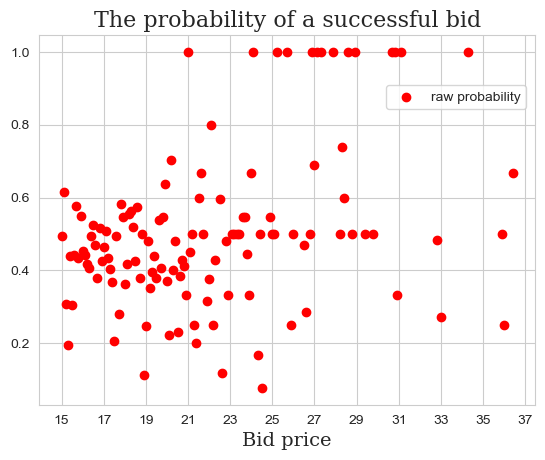

In [192]:
fig

Several things jump out from the figure:
1. there are a lot of bid prices with 100% probability of winning.
2. there are lots of bids at the floor price.
to be precise 

Step 1: Extraction of data from the submitted bids 'bres' and accepted bids 'om' files.

Start with the submitted bids, will take the data for one, and only one floor price 'sflr' $=$ 15

In [3]:
df_0409 = dd.read_json('bres_0409.json', blocksize="128 MiB", lines=True) # load the json file

In [8]:
df_0409.head() # take a look

,level,demand_partner,opn,dbpr,sbpr,dflr,sflr,publisher_id,kgrp,bidrequest,bidresponse,time,message
0,info,freewheel,1.1,2.250924,2.125462,2.1,2.0,18000792,c,"{""id"":""b97c3bdb-cd9d-439e-8562-4ccd52245965"",""...","{'id': 'b97c3bdb-cd9d-439e-8562-4ccd52245965',...",2024-04-09T00:00:00Z,response
1,info,freewheel,1.4,2.325414,2.000000,2.1,2.0,18000792,t,"{""id"":""1cbcb65d-1f4c-4f03-bdc6-8f92be484672"",""...","{'id': '1cbcb65d-1f4c-4f03-bdc6-8f92be484672',...",2024-04-09T00:00:00Z,response
2,info,wurl,1.4,12.000000,10.000000,10.5,10.0,109759,c,"{""id"":""78f06a03-ece8-4113-bdc5-e03d488bb32f"",""...","{'id': '78f06a03-ece8-4113-bdc5-e03d488bb32f',...",2024-04-09T00:00:00Z,response
3,info,bidswitch,3.4,17.112000,16.000000,18.4,16.0,94372221,t,"{""id"":""coa8a05itjdcn86dc5g0"",""imp"":[{""id"":""520...","{'id': 'coa8a05itjdcn86dc5g0', 'seatbid': [{'b...",2024-04-09T00:00:00Z,response
4,info,wurl,2.4,12.000000,10.000000,11.0,10.0,109759,t,"{""id"":""b2106c3b-9688-47d9-9cdc-7c57a4446e54"",""...","{'id': 'b2106c3b-9688-47d9-9cdc-7c57a4446e54',...",2024-04-09T00:00:00Z,response


In [9]:
df1_0409 = df_0409.drop(['level', 'demand_partner', 'opn', 'dbpr', 'dflr', 'kgrp', 'message','bidresponse'], axis=1)
df_raw0409_15 = df1_0409[df1_0409['sflr']== 15.0].drop(['sflr'], axis=1).reset_index(drop=True) # drop redundant fields

In [25]:
df_raw0409_15  = df_raw0409_15.compute()

In [26]:
df_raw0409_15.head()

,sbpr,publisher_id,bidrequest,time
0,15.0,650003,"{""id"":""51821639-48a2-447b-b5de-aee0beb878bd"",""...",2024-04-09T00:00:01Z
1,15.0,650003,"{""id"":""5aa54938-a3a7-447b-b6cf-14b43764f8e3"",""...",2024-04-09T00:00:01Z
2,15.0,650003,"{""id"":""37b89a1e-e9e3-4697-a7f9-e20f0906fd30"",""...",2024-04-09T00:00:02Z
3,16.5,650003,"{""id"":""ee6d522b-838e-4ecd-bb10-71637c4b0505"",""...",2024-04-09T00:00:03Z
4,15.0,650003,"{""id"":""97253b20-00e5-445c-90c0-8cdf19da12c6"",""...",2024-04-09T00:00:03Z


In [27]:
def extract_features(df_raw):
    """ extract features from bidreqeust column"""
    list = []
    for i in range(len(df_raw)):
        d1 = {k:v for k,v in json.loads(df_raw.bidrequest.iloc[i]).items() if k not in ['source','at','tmax','user','regs']}
        d2 = {}
        d2['id'] = d1['id']
        if 'minduration' in d1['imp'][0]['video'].keys():
            d2['minduration'] = d1['imp'][0]['video']['minduration']
        else: d2['minduration'] = np.nan
        d2['maxduration'] = d1['imp'][0]['video']['maxduration']
        d2['minbitrate']= d1['imp'][0]['video']['minbitrate']
        d2['maxbitrate']= d1['imp'][0]['video']['maxbitrate']  
        if 'app' in d1.keys():
            if 'id' in d1['app'].keys():
                d2['app_id'] = d1['app']['id']
            else: d2['app_id'] = np.nan
            if 'name' in d1['app'].keys():
                d2['app_name'] = d1['app']['name']
            else: d2['app_name'] = np.nan
            if 'bundle' in d1['app'].keys():
                d2['app_bundle'] = d1['app']['bundle']
            else: d2['app_bundle'] = np.nan
            d2['app_pub_id'] = d1['app']['publisher']['id']
            if 'content' in d1['app'].keys():
                if 'genre' in d1['app']['content'].keys():
                    d2['genre'] = d1['app']['content']['genre']
                else: d2['genre'] = np.nan
                if 'language' in d1['app']['content'].keys():
                    d2['language'] = d1['app']['content']['language']
                else: d2['language'] = np.nan
            else: d2['genre'] = d2['language'] = np.nan
        else: d2['app_id'] = d2['app_bundle']= d2['app_pub_id'] = d2['genre'] = d2['language'] = np.nan
        d2['device_make'] = d1['device']['make']
        if 'model' in d1['device'].keys():
            d2['device_model'] = d1['device']['model']
        else: d2['device_model'] = np.nan
        if 'os' in d1['device'].keys():
            d2['device_os'] = d1['device']['os']
        else: d2['device_os'] = np.nan
        if 'language' in d1['device'].keys():
            d2['device_language'] = d1['device']['language']
        else: d2['device_language'] = np.nan
        if 'geo' in d1['device'].keys() and 'region' in d1['device']['geo'].keys():
            d2['geo_region'] = d1['device']['geo']['region']
        else: d2['geo_region'] = np.nan
        if 'geo' in d1['device'].keys() and 'metro' in d1['device']['geo'].keys():
            d2['geo_metro'] = d1['device']['geo']['metro']
        else: d2['geo_metro'] = np.nan
        list.append(d2)
    df_cl = pd.DataFrame(list)
    return df_cl

In [28]:
df_extr0409_15 = extract_features(df_raw0409_15)

In [29]:
df_extr0409_15.head()

,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,language,device_make,device_model,device_os,device_language,geo_region,geo_metro
0,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,Plex,G15147002586,1034,entertainment,NaN,Samsung,Tizen TV,Tizen,en,SC,546
1,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"SLING: Live TV, Shows & Movies",com.sling,1034,NaN,NaN,Generic,Generic Android TV,Android,en,OH,NaN
2,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,Plex,G15147002586,1034,entertainment,NaN,Samsung,Tizen TV,Tizen,en,TN,691
3,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fuboTV: Watch Live Sports & TV,905401434,1034,NaN,en,Apple,TV A1625,Other,en,GA,524
4,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fuboTV: Watch Live Sports & TV,905401434,1034,NaN,en,Apple,TV A1625,Other,en,GA,524


In [30]:
df_extr0409_15.index.nunique()

1176608

In [63]:
"""add time column from the raw file"""
time = pd.to_datetime(df_raw0409_15.time)
hour = pd.to_datetime(df_raw0409_15.time).dt.hour

In [64]:
df_extr0409_15_plus = df_extr0409_15.assign(hour=hour,time=time,sbpr=df_raw0409_15.sbpr)
df_extr0409_15_plus.head()

,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,language,device_make,device_model,device_os,device_language,geo_region,geo_metro,hour,time,sbpr
0,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,Plex,G15147002586,1034,entertainment,NaN,Samsung,Tizen TV,Tizen,en,SC,546,0,2024-04-09 00:00:01+00:00,15.0
1,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"SLING: Live TV, Shows & Movies",com.sling,1034,NaN,NaN,Generic,Generic Android TV,Android,en,OH,NaN,0,2024-04-09 00:00:01+00:00,15.0
2,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,Plex,G15147002586,1034,entertainment,NaN,Samsung,Tizen TV,Tizen,en,TN,691,0,2024-04-09 00:00:02+00:00,15.0
3,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fuboTV: Watch Live Sports & TV,905401434,1034,NaN,en,Apple,TV A1625,Other,en,GA,524,0,2024-04-09 00:00:03+00:00,16.5
4,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fuboTV: Watch Live Sports & TV,905401434,1034,NaN,en,Apple,TV A1625,Other,en,GA,524,0,2024-04-09 00:00:03+00:00,15.0


In [65]:
"""this concludes the cleaning of the submitted bids file"""
df_extr0409_15_plus.to_pickle("bres_0409_15_clean")

Continue with extracting data from the accepted bids file.

In [68]:
om_raw = pd.read_json('om_0409.json', lines=True)

In [69]:
om_raw.head()

,level,fields,time,message
0,info,{'_om': ['LhYGClQLOAYBGwgmHBdLLB0EQQgKOBcIVAk8...,2024-04-09T00:00:02Z,om-imp
1,info,{'_om': ['LhYGClQeIQQKDBUuABALKgEaSQoBIEMFDRQ6...,2024-04-09T00:00:04Z,om-imp
2,info,{'_om': ['LhYGClQbIwgHRwQsHEIEKwcbC1RFZk5PQkpj...,2024-04-09T00:00:05Z,om-imp
3,info,{'_om': ['LhYGClQDLAsBCwhmCgsIaRMNEhsCcE5PQkpj...,2024-04-09T00:00:09Z,om-imp
4,info,{'_om': ['LhYGCVRfawQAHBMkVAwROwIaQlovaFciTFMO...,2024-04-09T00:00:10Z,om-imp


In [71]:
om_raw.columns

Index(['level', 'fields', 'time', 'message'], dtype='object')

In [72]:
om_raw.drop(['level', 'time', 'message'], axis=1, inplace=True)

In [73]:
def clean_om(row):
    d = {}
    for k,v in row.fields.items():
        if k == 'bdid':
            d[k] = v[0]
        if k == 'sflr':
            d[k] = float(v[0])
        if k == 'sbpr':
            d[k] = float(v[0])
    return d

In [74]:
om_clean_0409 = om_raw.apply(clean_om, axis=1, result_type='expand')

In [75]:
om_clean_0409.head()

,bdid,sbpr,sflr
0,1cca5f27-4ebf-4912-8f74-056f14c7df05,7.5000,5.5
1,7bb13811-7b59-4d0d-ba1d-1941455813c1,2.0000,2.0
2,ecc9b610-52c7-48b4-8d1d-4413efe378af,11.2000,10.0
3,85c980e3-fb1a-469f-8b5a-782731d71832,15.1533,13.0
4,0f8e3f1c-30ca-4e62-bbc8-a18aa54817b3,7.0000,7.0


In [76]:
om_clean_0409.to_pickle('om_clean_0409.pkl')

In [78]:
df_om= pd.read_pickle("om_clean_0409.pkl")

Now, use the successful bids from tthe 'om' file to mark those in tthe submitted bids 'bres' file.
The field 'bdid' in the 'om' file matches the field 

In [79]:
bdid_set = set(om_clean_0409[om_clean_0409.sflr == 15.0].bdid)

In [81]:
df_extr0409_15_plus['data'] = df_extr0409_15.apply(lambda row: row.id in bdid_set, axis=1)
df_extr0409_15_plus.head()

,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,...,device_make,device_model,device_os,device_language,geo_region,geo_metro,hour,time,sbpr,data
0,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,Plex,G15147002586,1034,entertainment,...,Samsung,Tizen TV,Tizen,en,SC,546,0,2024-04-09 00:00:01+00:00,15.0,False
1,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"SLING: Live TV, Shows & Movies",com.sling,1034,NaN,...,Generic,Generic Android TV,Android,en,OH,NaN,0,2024-04-09 00:00:01+00:00,15.0,False
2,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,Plex,G15147002586,1034,entertainment,...,Samsung,Tizen TV,Tizen,en,TN,691,0,2024-04-09 00:00:02+00:00,15.0,False
3,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fuboTV: Watch Live Sports & TV,905401434,1034,NaN,...,Apple,TV A1625,Other,en,GA,524,0,2024-04-09 00:00:03+00:00,16.5,False
4,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fuboTV: Watch Live Sports & TV,905401434,1034,NaN,...,Apple,TV A1625,Other,en,GA,524,0,2024-04-09 00:00:03+00:00,15.0,False


Everything is ready to plot the probability of a bid to go through

In [132]:
# need to round off the prices first
df_extr0409_15_plus.sbpr = df_extr0409_15_plus.sbpr.round(1)
df_extr0409_15_plus.sbpr.head()

0    15.0
1    15.0
2    15.0
3    16.5
4    15.0
Name: sbpr, dtype: float64

In [133]:
df_all = pd.DataFrame(df_extr0409_15_plus.groupby(['sbpr'])['sbpr'].count())
df_all.rename(columns={"sbpr":"total_count"}, inplace=True)
df_all.head()

,total_count
sbpr,
15.0,1018350
15.1,552
15.2,3151
15.3,571
15.4,5705


In [134]:
df_true = pd.DataFrame(df_extr0409_15_plus[df_extr0409_15_plus.data==True].groupby(['sbpr'])['sbpr'].count())
df_true.rename(columns={"sbpr":"true_count"}, inplace=True)
df_true.head()

,true_count
sbpr,
15.0,502278
15.1,339
15.2,966
15.3,111
15.4,2505


In [135]:
df_prob = pd.concat([df_all,df_true], axis=1)
df_prob.head()

,total_count,true_count
sbpr,,
15.0,1018350,502278.0
15.1,552,339.0
15.2,3151,966.0
15.3,571,111.0
15.4,5705,2505.0


In [137]:
df_prob["prob"] = df_prob.apply(lambda row: row.true_count/row.total_count, axis=1)
df_prob.head(20)

,total_count,true_count,prob
sbpr,,,
15.0,1018350,502278.0,0.493227
15.1,552,339.0,0.614130
15.2,3151,966.0,0.306569
15.3,571,111.0,0.194396
15.4,5705,2505.0,0.439089
15.5,3370,1025.0,0.304154
15.6,45743,20196.0,0.441510
15.7,410,237.0,0.578049
15.8,5109,2215.0,0.433549


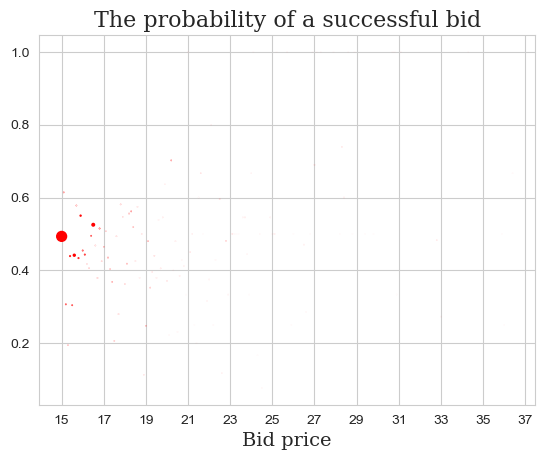

In [190]:
plt.scatter(x = df_prob.index, y= df_prob.prob, color = 'r', s = df_prob.true_count*0.0001 )
plt.xticks(np.arange(15, 39, step=2))
plt.xlabel('Bid price',fontsize=14,fontfamily='serif')
plt.title("The probability of a successful bid", fontsize=16, fontfamily='serif')
plt.savefig('Bid probability before.png')

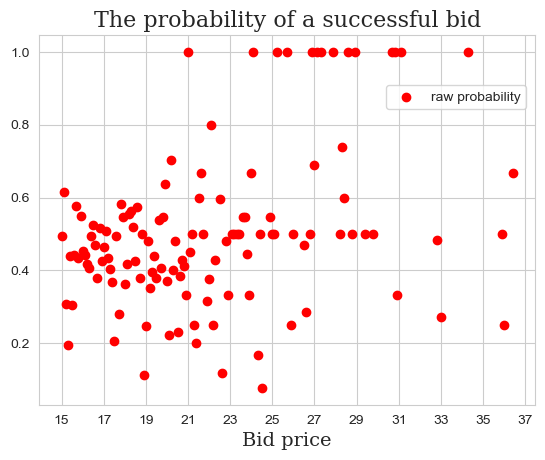

In [206]:
fig_prob, ax  = plt.subplots()
plt.title("The probability of a successful bid", fontsize=16, fontfamily='serif')
ax.scatter(x= df_prob.index, y= df_prob.prob, color = 'r' )
ax.set_xlabel('Bid price',fontsize=14,fontfamily='serif')
ax.set_xticks(np.arange(15, 39, step=2))
ax.legend(['raw probability'], loc=(0.7,0.8))
plt.savefig('Bid probability before.png')


In [197]:
fraction_of_all_bids = df_prob[df_prob.index == 15.0].total_count/df_prob.total_count.sum()
fraction_of_all_bids

sbpr
15.0    0.865496
Name: total_count, dtype: float64

In [198]:
fraction_of_om_bids = df_prob[df_prob.index == 15.0].true_count/df_prob.true_count.sum()
fraction_of_om_bids

sbpr
15.0    0.869065
Name: true_count, dtype: float64